In [1]:
import numpy as np
import sys
sys.path.append('/Users/eframe/dmi/src')
import eventAnalysis as ea
import tables
import matplotlib.pyplot as plt
from matplotlib import cm
import codedAperture as ca
import calibrate as calib
import scipy.stats
from matplotlib.animation import FuncAnimation
import matplotlib
from mpl_toolkits import mplot3d
from matplotlib.font_manager import FontProperties

In [2]:
def is_prime(n):
    for i in range( 2, n ):
        if ( n % i ) == 0:
            return False
    return True

In [3]:
def quadresiduals( p ):
    arr = []
    for i in np.arange( p ):
        arr.append( i ** 2  % p )
    return np.unique( arr )

In [4]:
def MURA(p):
    pattern = np.zeros( ( p, p ) )
    quadres = quadresiduals( p )
    if is_prime( p ):
        for i in np.arange(p):
            if np.isin( i, quadres ):
                Ci = 1
            else:
                Ci = -1
            for j in np.arange( p ):
                if np.isin( j, quadres ):
                    Cj = 1
                else:
                    Cj = -1
                if j == 0:
                    pattern[i][j] = 1
                elif ( j !=0 ) & ( i == 0 ):
                    pattern[i][j] = 0
                elif ( Ci * Cj == 1 ):
                    pattern[i][j] = 0
                elif ( Ci * Cj == -1 ):
                    pattern[i][j] = 1
        return pattern
    else: 
        print( 'Not a prime number!')


In [5]:
pattern1 = np.fliplr( MURA(31) )
pattern2 = pattern1[:, :-1]
patterntop = np.concatenate( ( pattern1, pattern2 ), axis=1 )
patternbottom = patterntop[1:, :]
maskMURA = np.concatenate( ( patternbottom, patterntop ) )
maskMURA.shape

(61, 61)

In [6]:
mFile = '/Users/eframe/dmi/mask.mat'
data = scipy.io.loadmat(mFile)
maskRandom = data['Mopt']

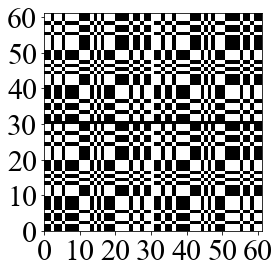

In [7]:
%matplotlib inline
font = FontProperties()
font.set_name('Times New Roman')
binSize = 2
fig, ax = plt.subplots()
im = ax.pcolormesh(maskMURA.T, cmap='Greys')
ax.set_aspect('equal', adjustable='box')
for l in ax.xaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(30)
for l in ax.yaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(30)
plt.show()

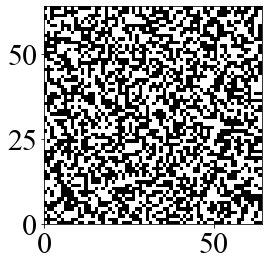

In [8]:
%matplotlib inline
font = FontProperties()
font.set_name('Times New Roman')
binSize = 2
fig, ax = plt.subplots()
im = ax.pcolormesh(maskRandom.T, cmap='Greys')
ax.tick_params(labelsize=30)
ax.set_aspect('equal', adjustable='box')
for l in ax.xaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(30)
for l in ax.yaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(30)
plt.show()

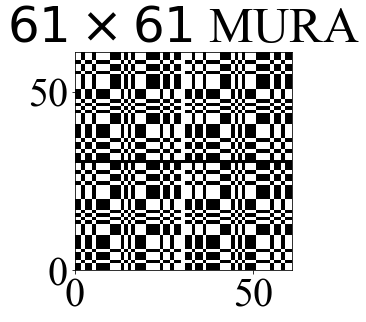

In [9]:
%matplotlib inline
font = FontProperties()
font.set_name('Times New Roman')
binSize = 2
fig, ax = plt.subplots()
im = ax.pcolormesh(maskMURA.T, cmap='Greys')
ax.tick_params(labelsize=40)
# ax.xaxis.set_ticks(np.arange(0, 65, 8))
# ax.yaxis.set_ticks(np.arange(0, 65, 8))
ax.set_aspect('equal', adjustable='box')
ax.set_title(r'$61\times61$ MURA', font=font, fontsize = 50)
for l in ax.xaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)
for l in ax.yaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)
plt.show()

In [131]:
m = 4
mask = maskRandom
n_m = len( mask.flatten() )
n_s = len( mask.flatten() ) / ( 4 * m ** 2 ) # total number of bins in submatrix
# n_s = 31*31 # for MURA at m=1
a = int( np.sqrt( n_s ) / 2 ) 
b = int( np.sqrt( n_m ) / 2 )
l = 0 # 1 for MURA at m=2 and m=4
u = 6
v = 10
# u = 0
# v = 0
A = mask[ b-a-u:b+a-u+l, b-a-v:b+a-v+l ].flatten() 
shifts = int( np.sqrt( n_m ) - np.sqrt( n_s ) ) + 1
val = []
I = int( np.sqrt( n_s ) ) 
for i in np.arange( shifts ):
    for j in np.arange( shifts ):
        G = mask[ i:i + I, j:j + I ].flatten() 
        psf = np.correlate( A, G.astype(int) ) / len(G)       
        val.extend( psf )   
val = np.array( val ).reshape( ( shifts, shifts ) ) 

In [132]:
G

array([0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1],
      dtype=uint8)

In [133]:
G.astype(int)

array([0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1])

In [123]:
sidelobes = np.delete( val.flatten(), np.argmax(val) )
N = len( sidelobes )
mins = min( sidelobes )
maxs = max( sidelobes )
mu = np.mean( sidelobes )
std = np.std( sidelobes )
var = np.var( sidelobes )
kurt = scipy.stats.kurtosis( sidelobes, fisher=False )
print( mu, std, var, kurt, )

0.25131674373851104 0.007516001725972216 5.649028194481733e-05 3.0068951130943007


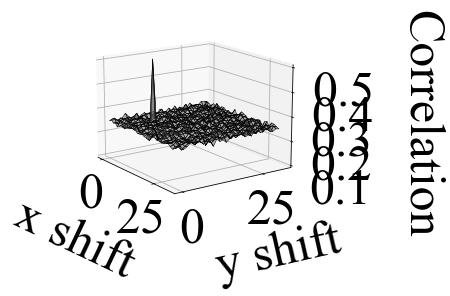

In [124]:
%matplotlib inline
font = FontProperties()
font.set_name('Times New Roman')
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_aspect('auto')
x, y = np.arange( val.shape[0] ), np.arange( val.shape[0] )
X, Y = np.meshgrid(x, y)
surf = [ax.plot_surface(X, Y, val[:, :], color='grey', alpha = 0.5, rstride=1, cstride=1, linewidth=0.5, edgecolors='k')]
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('Correlation', rotation = 270, fontsize=50,fontproperties=font, labelpad=50)
ax.set_xlabel('x shift', fontsize=50, fontproperties=font, labelpad=35)
ax.set_ylabel('y shift', fontsize=50, fontproperties=font, labelpad=35)
ax.tick_params( labelsize=50 )
ax.tick_params( axis='z',pad=20 )
ax.view_init(15, -35)
ax.zaxis.set_ticks(np.arange(0.1, 0.6, 0.1))
for l in ax.xaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(50)
for l in ax.yaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(50)
for l in ax.zaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(50)